In [1]:
%matplotlib inline

In [109]:
from collections import defaultdict
from itertools import combinations
import numpy as np
import pandas as pd
import time
import glob
from multiprocessing import Pool
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import KFold, cross_val_score
import matplotlib
from random import sample
import pickle
# from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

chr_border - проверил ручками, вроде работает

In [3]:
file_f = 'data/ci3382.txt'
file_m = 'data/fb1659.txt'
length_desc_file = 'data/conv_autosomes_mod.txt'

In [4]:
def read_chip_seq2(file):
    df = pd.read_csv(file, header=None, sep='/').values
    return(i for i in df)

In [5]:
def read_map(file):
    fl = open(file)
    lst = []
    chr_border = {}
    
    last_chr = 1
    last_chr_begin = 0
    
    for position, strs in enumerate(fl):
        strs_split = strs.split()
        lst.append({'chr':int(strs_split[0]), 'start':int(strs_split[1]), 'abs_dist':float(strs_split[2]), \
                    'delta_dist':float(strs_split[3])})
        
        if last_chr != int(strs_split[0]):
            chr_border[last_chr] = (last_chr_begin, position-1)
            last_chr_begin = position
        last_chr = int(strs_split[0])

    chr_border[22] = (last_chr_begin, position-1)
            
        
    return(lst, chr_border)  

In [6]:
def find_IBD_segment(postions, chromosome, min_SNP=300, min_len=0.03):
    lst = sorted(list(set(postions)))
    tmp = []
    #print(lst)
    for number, SNP_pos in enumerate(lst[:-1]):
        if lst[number+1] - SNP_pos >= min_SNP and \
        length_desc[lst[number+1]]['abs_dist'] - length_desc[SNP_pos]['abs_dist'] > min_len:
            number_of_SNP = lst[number+1] - SNP_pos
            len_cm = length_desc[lst[number+1]]['abs_dist'] - length_desc[SNP_pos]['abs_dist']
            
            d = {'start':SNP_pos+1, 'end':lst[number+1]-1, 'numeber_of_SNP':number_of_SNP, 'len_cm':len_cm, \
                'chr':chromosome}
            tmp.append(d)
    return(tmp)

In [7]:
def calculate_all_IBD2(file_f, file_m, verbose=0):
    start_time = time.time()
    seq_ff = read_chip_seq2(file_f)
    seq_mm = read_chip_seq2(file_m)
    if verbose: print('for read and parse:', time.time() - start_time)
    
    start_time = time.time()
    homozygotes_position = defaultdict(list)
    # find homozygotes position

    for i in range(number_of_chip_elemnt):
        seq_f = next(seq_ff)
        seq_m = next(seq_mm)
        if seq_f[0] == seq_f[1] and seq_m[0] == seq_m[1] and seq_f[0] != seq_m[0]:
            homozygotes_position[length_desc[i]['chr']].append(i)
            
    save_dict = []
    for chromose in range(1, 23):
        to_analysis = homozygotes_position[chromose]
        to_analysis.insert(0, chr_border[chromose][0])
        to_analysis.append(chr_border[chromose][1])
        save_dict.append(find_IBD_segment(to_analysis, chromose, 300, 5))

    d = []
    for i in save_dict:
        d += i

    # index=['start', 'stop', 'numeber_of_SNP', 'len']
    df = pd.DataFrame(d, columns=['chr', 'start', 'end', 'numeber_of_SNP', 'len_cm']) 
    if verbose: print('for processing data:', time.time() - start_time)
    return(df)

In [8]:
def for_par(arg):
    file_f = arg[0]
    file_m = arg[1]
    df = calculate_all_IBD2(file_f, file_m, verbose=0)
    # print(sorted([file_f.split('/')[-1], file_m.split('/')[-1]]))
    key = tuple(sorted([file_f.split('/')[-1], file_m.split('/')[-1]]))
    # print(key)
    return({key:df})

In [9]:
def for_par_many_folder(arg):
    file_f = arg[0]
    file_m = arg[1]
    #return({'a':file_f, 'b':file_m})
    df = calculate_all_IBD2(file_f, file_m, verbose=0)
    n_row = df.shape[0]
    s = df.sum()
    return({'numeber_of_SNP':s['numeber_of_SNP'], 'len_cm':s['len_cm'], 'n_IDB':n_row}, df)

In [10]:
def process_colors(colors):
    color_dict = {}
    color_vec = sample([name for name, key in matplotlib.colors.cnames.items()], len(np.unique(colors)))
    for i, color in enumerate(np.unique(colors)):
        color_dict[color]=color_vec[i]

    fixed_color = np.array([color_dict[i] for i in colors])
    #np.unique(colors)
    return(fixed_color)

In [11]:
length_desc, chr_border = read_map(length_desc_file)
number_of_chip_elemnt = len(length_desc)
print(number_of_chip_elemnt)

533858


In [12]:
pool = Pool(6)

In [13]:
n_folder = 37
n_gen = 15

In [14]:
out = []
for_graph = []
full_data = []
for i in range(0, n_gen, 2):   
    print(i)
    arg2 = [('experiments_38/'+str(j)+'/'+str(i), 'experiments_38/'+str(j)+'/'+str(i+1)) for j in range(n_folder+1)]
    
    lst2 = pool.map(for_par_many_folder, arg2)
    full_df = [k[1] for k in lst2]
    lst = [k[0] for k in lst2]
    for j, i_i in enumerate(full_df):
        i_i['id'] = [arg2[j] for t in range(i_i.shape[0])]
        i_i['generation'] = [int(i/2+1) for t in range(i_i.shape[0])]
    for j in full_df:
        full_data += full_df
    
    #full_data.append(full_df)
    #break
    means = pd.DataFrame(lst).mean()
    out.append({'i':i, 'mean_len_cm':means['len_cm'], 'mean_numeber_of_SNP':means['numeber_of_SNP']})
    w = pd.DataFrame(lst, columns=['n_IDB', 'len_cm', 'numeber_of_SNP'])
    w['generation'] = int(i/2+1)
    for_graph.append(w)
    
print('i-cousen completed')

0
2
4
6
8
10
12
14
i-cousen completed


In [15]:
# parents-child
#pool = Pool(6)
for i in range(0, 1, 2):
    print(i)
    arg2= [('experiments_38/'+str(j)+'/'+str(i), 'experiments_38/'+str(j)+'/'+str(i+2)) \
                   for j in range(n_folder+1)]
    #arg2 += [('experiments_38/'+str(j)+'/'+str(i+1), 'experiments_38/'+str(j)+'/'+str(i+3)) \
    #                for j in range(n_folder+1)]
    #print(arg_parents)
    #break
    lst2 = pool.map(for_par_many_folder, arg2)
    full_df = [k[1] for k in lst2]
    lst = [k[0] for k in lst2]
    for j, i_i in enumerate(full_df):
        i_i['id'] = [arg2[j] for t in range(i_i.shape[0])]
        i_i['generation'] = [int(i/2+1) for t in range(i_i.shape[0])]
    for j in full_df:
        full_data += full_df
    
    
    means = pd.DataFrame(lst).mean()
    out.append({'i':i, 'mean_len_cm':means['len_cm'], 'mean_numeber_of_SNP':means['numeber_of_SNP']})
    w = pd.DataFrame(lst, columns=['n_IDB', 'len_cm', 'numeber_of_SNP'])
    w['generation'] = int(100)
    for_graph.append(w)
print('parents-childres completed')

0
parents-childres completed


In [16]:
# unclce
# pool = Pool(6)
for i in range(0, 1, 2):
    print(i)
    arg2 = [('experiments_38/'+str(j)+'/'+str(i), 'experiments_38/'+str(j)+'/'+str(i+3)) \
                   for j in range(n_folder+1)]
    #arg2 += [('experiments_38/'+str(j)+'/'+str(i+1), 'experiments_38/'+str(j)+'/'+str(i+2)) \
    #                for j in range(n_folder+1)]
    #print(arg_parents)
    lst2 = pool.map(for_par_many_folder, arg2)
    full_df = [k[1] for k in lst2]
    lst = [k[0] for k in lst2]
    for j, i_i in enumerate(full_df):
        i_i['id'] = [arg2[j] for t in range(i_i.shape[0])]
        i_i['generation'] = [int(i/2+1) for t in range(i_i.shape[0])]
    for j in full_df:
        full_data += full_df
        
        
    means = pd.DataFrame(lst).mean()
    out.append({'i':i, 'mean_len_cm':means['len_cm'], 'mean_numeber_of_SNP':means['numeber_of_SNP']})
    w = pd.DataFrame(lst, columns=['n_IDB', 'len_cm', 'numeber_of_SNP'])
    w['generation'] = int(120)
    for_graph.append(w)
print('uncle completed')

0
uncle completed


In [17]:
# grand_f_m
# pool = Pool(6)
for i in range(0, 1, 2):
    print(i)
    arg2 = [('experiments_38/'+str(j)+'/'+str(i), 'experiments_38/'+str(j)+'/'+str(i+4)) \
                   for j in range(n_folder+1)]
    #arg2 += [('experiments_38/'+str(j)+'/'+str(i+1), 'experiments_38/'+str(j)+'/'+str(i+5)) \
    #                for j in range(n_folder+1)]
    #print(arg_parents)
    lst2 = pool.map(for_par_many_folder, arg2)
    full_df = [k[1] for k in lst2]
    lst = [k[0] for k in lst2]
    for j, i_i in enumerate(full_df):
        i_i['id'] = [arg2[j] for t in range(i_i.shape[0])]
        i_i['generation'] = [int(i/2+1) for t in range(i_i.shape[0])]
    for j in full_df:
        full_data += full_df
        
    means = pd.DataFrame(lst).mean()
    out.append({'i':i, 'mean_len_cm':means['len_cm'], 'mean_numeber_of_SNP':means['numeber_of_SNP']})
    w = pd.DataFrame(lst, columns=['n_IDB', 'len_cm', 'numeber_of_SNP'])
    w['generation'] = int(140)
    for_graph.append(w)
print('grandparents completed')

0
grandparents completed


In [18]:
print(sum(i.shape[0] for i in for_graph))
result = pd.concat(for_graph, ignore_index=True)
print(result.shape[0])

418
418


In [19]:
e = pd.DataFrame(out)
e['number_of_generation'] = e.apply(lambda x: int(x[0] / 2 + 1), axis=1)
e.to_csv(path_or_buf='a.csv')

In [127]:
with open('result.pickle', 'wb') as f:
    pickle.dump(result, f, protocol=2)
with open('full_data.pickle', 'wb') as f:
    pickle.dump(full_data, f, protocol=2)

In [128]:
result.head()

n_IDB       len_cm  numeber_of_SNP  generation
0     27  2653.384948        392534.0           1
1     34  2523.666364        370543.0           1
2     33  2349.873527        367160.0           1
3     34  2960.206444        431628.0           1
4     33  2991.244995        443075.0           1

In [31]:
result.to_csv('res_yesterday.csv')

In [139]:
if 0:
    with open('from_cluster/result.pickle', 'rb') as f:
        result = pickle.load(f, encoding='latin1')
else:
    with open('result.pickle', 'rb') as f:
        result = pickle.load(f, encoding='latin1')
        
result.head()

n_IDB       len_cm  numeber_of_SNP  generation
0     27  2653.384948        392534.0           1
1     34  2523.666364        370543.0           1
2     33  2349.873527        367160.0           1
3     34  2960.206444        431628.0           1
4     33  2991.244995        443075.0           1

In [167]:
y = np.array(result['n_IDB'])
x = np.log2(np.array(result['len_cm']))
x = (np.array(result['len_cm']))
colors = np.array(result['generation'])
colors_chr = process_colors(colors)

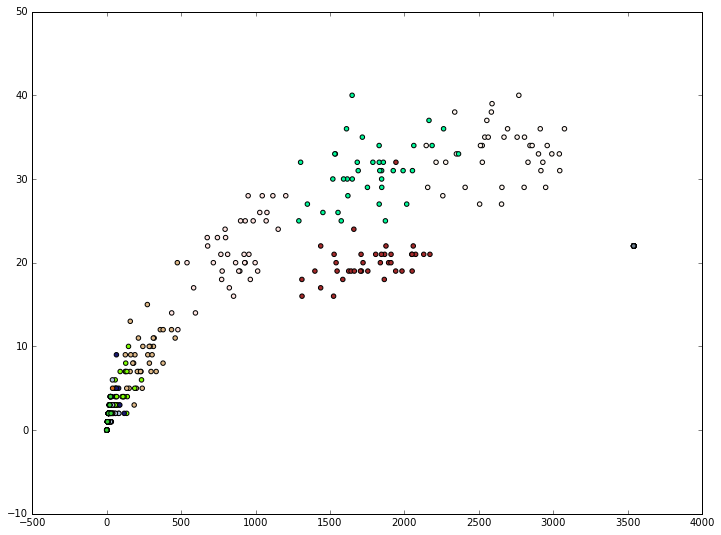

In [168]:
plt.rcParams["figure.figsize"] = [12, 9]
plt.scatter(x, y, c=colors_chr)
plt.show()

In [155]:
#y[(y >=5) & (y <= 8)] = 8

In [160]:
X = result.drop('generation', axis=1)
y = np.array(result['generation'])

cv = KFold(X.shape[0], n_folds=2, shuffle=True)

for i in np.unique(y):
    y_cur = np.array(result['generation'])
    y_cur[y_cur != i] = 0
    y_cur[y_cur== i] = 1
    
    
    estimator = RandomForestClassifier(n_estimators=150, max_depth=8, n_jobs=-1)
    accur = cross_val_score(estimator, X, y_cur, cv=cv).mean()
    auc_roc = cross_val_score(estimator, X, y_cur, cv=cv, scoring='roc_auc').mean()
    print(i, accur, auc_roc)
    
    
    

1 0.988038277512 0.998326823458
2 0.995215311005 0.999584487535
3 0.968899521531 0.969659475039
4 0.923444976077 0.869390581717
5 0.882775119617 0.767667805168
6 0.897129186603 0.820207559174
7 0.885167464115 0.776821566393
8 0.892344497608 0.879463700973
100 1.0 1.0
120 0.983253588517 0.993693693694
140 0.992822966507 0.998770049032


In [161]:
X = result.drop('generation', axis=1)
y = np.array(result['generation'])
y[(y >=4) & (y <= 8)] = 8

In [162]:
cv = KFold(X.shape[0], n_folds=3, shuffle=True)
estimator = RandomForestClassifier(n_estimators=150, max_depth=8, n_jobs=-1)
accur = cross_val_score(estimator, X, y, cv=cv)

In [163]:
accur.mean()

0.94251455978074683

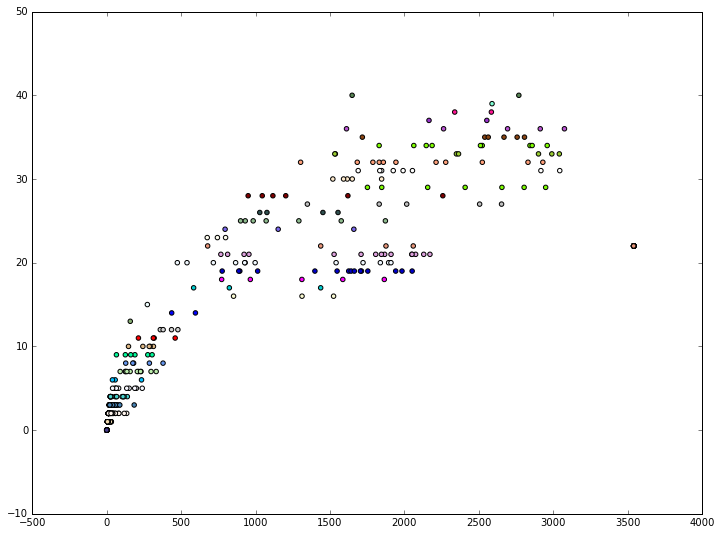

In [67]:
]

NameError: name 'MLPClassifier' is not defined